## Vector Search and Query Feedback

In this notebook, we encode The Movie DB descriptions using [Universal Sentence Encoder](https://towardsdatascience.com/use-cases-of-googles-universal-sentence-encoder-in-production-dd5aaab4fc15) or "USE". USE is a more classic embedding method, used to encode general meaning of the text. The techniques here could be applied to other kinds of embedding methods and large language models such as BERT, GPT, etc. 

Though embeddings often feel 'cutting edge' these techniques also rely on a classic Information Retrieval approach known as [Roccio Relevance Feedback](https://en.wikipedia.org/wiki/Rocchio_algorithm), which attempts to find the best vector for a given query, through metadata about what's clicked.

You'll see some of the challenges and power for using embedding based retrieval for search.

## Retrieve the tmdb and training data.

In [2]:
# !rm -rf data
![ ! -d 'data' ] && git clone https://github.com/ai-powered-search/tmdb.git data
!echo 'cloned'
! cd data && git pull
!echo 'pulled'

! cd data && tar -xvf movies.tgz  && tar -xvf judgments.tgz
![ ! -f 'data/title_judgments_logged.json.gz' ] && curl --location http://softwaredoug.com/data/title_judgments_logged.json.gz --output data/title_judgments_logged.json.gz

cloned
Already up to date.
pulled
x tmdb.json
x ai_pow_search_judgments.txt


In [3]:
import pandas as pd

tmdb = pd.read_json('data/tmdb.json').transpose()
tmdb['overview'] = tmdb['overview'].fillna('')
tmdb = tmdb.reset_index().rename(columns={'index': 'tmdb_id'})
tmdb.loc[tmdb['tmdb_id'] == 7555, :]

,tmdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,...,tagline,title,video,vote_average,vote_count,cast,directors,mlensId,status_message,status_code
16534,7555,False,/5W0ljXTtLVuLF0z8GE7mNXgTC44.jpg,"{'id': 5039, 'name': 'Rambo Collection', 'post...",10000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",http://www.rambofilm.com/,7555,tt0462499,en,...,Heroes never die... They just reload.,Rambo,False,6.5,2212,"[{'cast_id': 12, 'character': 'John Rambo', 'c...","[{'credit_id': '52fe4483c3a36847f809a9af', 'de...",NaN,NaN,NaN


In [4]:
import pandas as pd


judgments = pd.read_json('data/title_judgments_logged.json.gz')
judgments = judgments.rename(columns={'docId': 'doc_id'})
judgments

,uid,qid,keywords,doc_id,grade,features
0,17555,1,rambo,7555,4,"[11.657399, 10.083591]"
1,11370,1,rambo,1370,3,"[9.456276, 13.265001]"
2,11369,1,rambo,1369,3,"[6.036743, 11.113943]"
3,113258,1,rambo,13258,2,"[0.0, 6.8695450000000005]"
4,11368,1,rambo,1368,4,"[0.0, 11.113943]"
...,...,...,...,...,...,...
1385,4037079,40,star wars,37079,0,"[0.0, 0.0]"
1386,40126757,40,star wars,126757,0,"[0.0, 0.0]"
1387,4039797,40,star wars,39797,0,"[0.0, 0.0]"
1388,4018112,40,star wars,18112,0,"[0.0, 0.0]"


## Load the Universal Sentence Encoder (USE) model

We'll load the Universal Sentence Encoder model.

We chose the USE model due to its relatively fast inference and effectiveness on _shorter_ snippets of text (hence text). So in many cases its more appropriote for the short snippets of a few sentences like the TMDB movie overviews.

To show the output of USE, we encode a simple sentence.

In [5]:
import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)

model(["Mary had a little lamb"])

2023-01-16 16:23:46.836323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 16:23:46.836879: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-16 16:23:46.836907: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: AMD Radeon Pro 5300M


2023-01-16 16:23:49.138049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-16 16:23:50.734254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-0.07028453,  0.01059935,  0.08423027, -0.0328695 ,  0.02756505,
         0.00913632,  0.0239979 , -0.02628415,  0.03472483,  0.0650179 ,
         0.01685206, -0.02107863, -0.00316442,  0.01285157, -0.02940562,
        -0.06912368, -0.04474806, -0.02484763,  0.03213454, -0.08085862,
        -0.00281348, -0.010038  , -0.07211809, -0.06478165, -0.06929238,
        -0.07281128,  0.01756493,  0.01702456,  0.02819746,  0.01535106,
         0.03689979, -0.07985415, -0.05297632, -0.00374063,  0.03171751,
        -0.07539806,  0.00078359,  0.00415806,  0.03809249, -0.00017633,
         0.07057564, -0.0275983 , -0.01971644, -0.03484123, -0.07448607,
         0.02777741, -0.02331628,  0.00193907, -0.07192903, -0.02623207,
         0.01451908, -0.05442308, -0.0376509 , -0.04132596,  0.0610454 ,
         0.04082571,  0.02590919, -0.08042567,  0.01143595,  0.00482652,
        -0.07489359, -0.06260989, -0.08479565,  0.04441264,  0.01578628,
 

## Quick similarity check 

Let's define a simple [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) function between the two vectors that will tell us, on a scale from -1 to 1, how similar the two are. Because these are normalized vectors (their magnitude is 1), this is just the dot product.

Each vector is compared to the sentence "Mary Had a Little Lamb"

In [6]:
import numpy as np

mary_had_a_little_lamb = model(["Mary had a little lamb"])[0]

mary_had_a_little_sheep = model(["Mary had a little sheep"])[0]
susy_had_a_small_sheep = model(["Susie had a little sheep"])[0]
ed_had_a_smelly_dog = model(["Ed had a smelly dog"])[0]
its_tax_return_season = model(["Baby yoda is my accountant"])[0]


#
np.dot(mary_had_a_little_lamb, mary_had_a_little_sheep), \
np.dot(mary_had_a_little_lamb, susy_had_a_small_sheep), \
np.dot(mary_had_a_little_lamb, ed_had_a_smelly_dog), \
np.dot(mary_had_a_little_lamb, its_tax_return_season)

(0.79031765, 0.5826293, 0.235684, 0.16982538)

## Create an embedding value for each movie

We need an embedding for each 'overview' field value of the movie. We (annoyingly 😛) have to batch these up to end up with a numpy array that corresponds to each item in the text.

In [7]:
import tensorflow as tf

def divide_chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

text = tf.convert_to_tensor(tmdb['overview'].to_list())
batch_size = 1000
embeddings = tf.zeros([0, 512], dtype=tf.float32)
for idx, batch in enumerate(divide_chunks(text, batch_size)):
    predictions = model.predict(batch)
    embeddings = tf.concat([embeddings, predictions['outputs']], axis=0)
    
overview_use = embeddings.numpy()

2023-01-16 16:23:56.240175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


## Lets search!

Given: 

1. A way to encode a query string (the USE model)
2. The documents vectorized
3. A way to find teh similarity between (1) and (2)

We can now:

1. Rank the documents by most similar to the query is USE

To do that we'll devine some helper functions


In [9]:
def get_top_n(dotted, n=10):
    """Given dot product scored, get the top N."""
    n = min(n, dotted.shape[0])
    top_n = np.argpartition(-dotted, n-1)[:n]
    scores = dotted[top_n]
    return sorted(zip(top_n, scores),
                  key=lambda scored: scored[1],
                  reverse=True)

def nearest_neighbors(query_vector,  # Vector for the query
                      matrix,        # All the overviews
                      n=10):
    """ Get the row cosine scores AND the index into the 'matrix' """
    dotted = np.dot(matrix, query_vector)
    return get_top_n(dotted, n=n)

nearest_neighbors_rambo = nearest_neighbors(model(["rambo"])[0], overview_use, 10)
nearest_neighbors_rambo

[(33973, 0.5006161),
 (50104, 0.4745934),
 (50102, 0.43323624),
 (50103, 0.4262587),
 (40228, 0.41518188),
 (49213, 0.3776026),
 (65053, 0.35285836),
 (16903, 0.3371501),
 (16534, 0.32512662),
 (51881, 0.32369512)]

## OK but the actual documents...

**DISCUSSION** - what do we think of these results?

In [12]:
def keys(top):
    return [tp[0] for tp in top]

def scores(top):
    return [tp[1] for tp in top]

results = tmdb.iloc[keys(nearest_neighbors_rambo), :].copy() 

results['scores'] = scores(nearest_neighbors_rambo)

results[['title', 'tmdb_id', 'overview', 'scores']]

,title,tmdb_id,overview,scores
33973,The Last American Soldier,205697,Jungle action from the glorious period of Ramb...,0.500616
50104,Rambo III,1370,"Combat has taken its toll on Rambo, but he's f...",0.474593
50102,First Blood,1368,When former Green Beret John Rambo is harassed...,0.433236
50103,Rambo: First Blood Part II,1369,John Rambo is released from prison by the gove...,0.426259
40228,Nirbhay,493486,Action Film,0.415182
49213,"Marcel Hanoun, cinexperimentaux",406343,Art-House film,0.377603
65053,Rocky VI,60375,Not to be confused with any of the sequels to ...,0.352858
16903,John Wick,245891,Ex-hitman John Wick comes out of retirement to...,0.337150
16534,Rambo,7555,When governments fail to act on behalf of capt...,0.325127
51881,"There Is No Return, Johnny",523176,An American officer and a North Vietnamese pri...,0.323695


## Join with labeled judgments

Let's join these results with our labeled judgments to see how we did. We'll add a column 'grade' that is the label for the query 'rambo' for this movie.

Notice a few interesting things:

1. The first movie is not really relevant, but a *related* movie
2. We DO have several Rambo movies - great!
3. We have several unrated Rambo movies - Rocky IV - neat!

However, out of the box, these might not be what you'd want for search. It's more discovery oriented, and returning a mix of interesting results and actual matches. Let's see if we can do better.

In [15]:
results.merge(judgments[judgments['keywords'] == 'rambo'], how='left', left_on='tmdb_id', right_on='doc_id')[['title', 'tmdb_id', 'overview', 'scores', 'grade']]

,title,tmdb_id,overview,scores,grade
0,The Last American Soldier,205697,Jungle action from the glorious period of Ramb...,0.500616,NaN
1,Rambo III,1370,"Combat has taken its toll on Rambo, but he's f...",0.474593,3.0
2,First Blood,1368,When former Green Beret John Rambo is harassed...,0.433236,4.0
3,Rambo: First Blood Part II,1369,John Rambo is released from prison by the gove...,0.426259,3.0
4,Nirbhay,493486,Action Film,0.415182,NaN
5,"Marcel Hanoun, cinexperimentaux",406343,Art-House film,0.377603,NaN
6,Rocky VI,60375,Not to be confused with any of the sequels to ...,0.352858,NaN
7,John Wick,245891,Ex-hitman John Wick comes out of retirement to...,0.337150,NaN
8,Rambo,7555,When governments fail to act on behalf of capt...,0.325127,4.0
9,"There Is No Return, Johnny",523176,An American officer and a North Vietnamese pri...,0.323695,NaN


## How can we do better?

In [124]:
# Map doc_id -> row to find the right array in overview vector space
doc_ids = judgments['doc_id'].unique()
doc_ids

array([ 7555,  1370,  1369, ..., 39797, 18112, 43052])

In [125]:
tmdb[tmdb['id'].isin(doc_ids)]

,tmdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,...,tagline,title,video,vote_average,vote_count,cast,directors,mlensId,status_message,status_code
5,43008,False,/nbUnIkRlBmUEnI3Y9shgirevAvc.jpg,None,0,"[{'id': 37, 'name': 'Western'}]",,43008,tt0052876,en,...,From The Prize Novel -- A Picture Of Thunderin...,The Hanging Tree,False,6.5,42,"[{'cast_id': 2, 'character': 'Dr. Joseph 'Doc'...","[{'credit_id': '52fe4626c3a36847f80ef88b', 'de...",NaN,NaN,NaN
35,43052,False,None,None,0,"[{'id': 18, 'name': 'Drama'}]",,43052,tt0803080,en,...,,Säg att du älskar mig,False,4.6,4,[],"[{'credit_id': '54c2afa092514124ed004162', 'de...",NaN,NaN,NaN
103,43189,False,/wWO1oD6O1ytXKNQEBOsjRGyscvu.jpg,None,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",,43189,tt0044903,en,...,Inspired by the true story of bathing beauties!,Million Dollar Mermaid,False,6.0,8,"[{'cast_id': 1, 'character': 'Annette Kellerma...","[{'credit_id': '52fe4633c3a36847f80f2311', 'de...",NaN,NaN,NaN
164,43317,False,/umEJ78FUDu6DyOOYAgLjT48Hynk.jpg,None,1500000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",,43317,tt0047840,en,...,,Artists and Models,False,6.9,50,"[{'cast_id': 2, 'character': 'Rick Todd', 'cre...","[{'credit_id': '52fe463dc3a36847f80f3f43', 'de...",NaN,NaN,NaN
304,43522,False,/cuMRzYkcv8LgpGf2Oi0kHYY5HCX.jpg,None,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",,43522,tt0034778,en,...,"The grandest story of the Naughty ""Nineties"" b...",Gentleman Jim,False,7.0,25,"[{'cast_id': 2, 'character': 'James J. Corbett...","[{'credit_id': '52fe464ec3a36847f80f7cdd', 'de...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65469,82866,False,/tZvPiAZPHWvE6yjd8RI0b3CWWnm.jpg,None,0,"[{'id': 99, 'name': 'Documentary'}]",,82866,tt0996396,en,...,,Fog City Mavericks,False,0.0,0,"[{'order': 0, 'id': 1, 'cast_id': 1, 'credit_i...","[{'id': 223388, 'department': 'Directing', 'cr...",101133,NaN,NaN
65523,28323,False,/kcMcA9EbWfUtyHLMq6MdIHAWSaL.jpg,None,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",,28323,tt0073138,en,...,,I Will Fight No More Forever,False,3.3,3,"[{'order': 0, 'id': 6577, 'cast_id': 1, 'credi...","[{'id': 35525, 'department': 'Directing', 'cre...",107638,NaN,NaN
65595,195617,False,None,None,0,[],,195617,tt0021004,en,...,,It's a Bird,False,8.0,2,"[{'order': 0, 'id': 1067965, 'cast_id': 2, 'cr...","[{'id': 1067966, 'department': 'Directing', 'c...",125956,NaN,NaN
65674,130745,False,None,None,0,"[{'id': 99, 'name': 'Documentary'}]",,130745,tt2234419,en,...,,16 Acres,False,6.5,2,[],"[{'id': 126162, 'department': 'Directing', 'cr...",110582,NaN,NaN


## Build weighted query embeddings

Create an embedding for each query in the document space by following the [Rocchio Algorithm](https://en.wikipedia.org/wiki/Rocchio_algorithm). This is an algorithm from the _1960s_!. 

As per the diagram from [Wikipedia](https://commons.wikimedia.org/wiki/File:Rocchioclassgraph.jpg), Rocchio simply takes a weighted average of all the overview vectors for the relevant documents of the query. As we'll see this classic method, alongside really good embeddings, works very well!

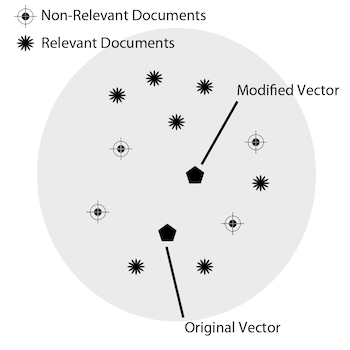

In [51]:
judgments['weight'] = (judgments['grade'] / 4)
judgments

,uid,qid,keywords,doc_id,grade,features,weight
0,17555,1,rambo,7555,4,"[11.657399, 10.083591]",1.00
1,11370,1,rambo,1370,3,"[9.456276, 13.265001]",0.75
2,11369,1,rambo,1369,3,"[6.036743, 11.113943]",0.75
3,113258,1,rambo,13258,2,"[0.0, 6.8695450000000005]",0.50
4,11368,1,rambo,1368,4,"[0.0, 11.113943]",1.00
...,...,...,...,...,...,...,...
1385,4037079,40,star wars,37079,0,"[0.0, 0.0]",0.00
1386,40126757,40,star wars,126757,0,"[0.0, 0.0]",0.00
1387,4039797,40,star wars,39797,0,"[0.0, 0.0]",0.00
1388,4018112,40,star wars,18112,0,"[0.0, 0.0]",0.00


In [52]:
def get_embedding(tmdb_id):
    return overview_use[tmdb[tmdb['tmdb_id'] == tmdb_id].index]


# Dial controlling proportion of grades should come from query. Value between 0-1
QUERY_WEIGHT=0.0  # SET FROM 0 TO 1

query_embeddings = {}
for query in judgments['keywords'].unique():
    
    just_query = model([query])[0]    
    
    query_judgments = judgments[judgments['keywords'] == query]
    
    for query_judgment in query_judgments.to_dict(orient='records'):
        tmdb_id = query_judgment['doc_id']
        weight = query_judgment['weight']
        doc_embedding = get_embedding(tmdb_id)[0]

        # Add in this doc's embedding for the query
        try:
            query_embeddings[query] += (weight * doc_embedding)
        except KeyError:
            query_embeddings[query] = weight * doc_embedding 
            
    # Combine with query, with query weight QUERY_WEIGHT                        
    # Take an average, and normalize (magnitude to 1) so dot prod works
    query_embeddings[query] /= len(query_judgments)
    
    # Add in some amount of query weight based on QUERY_WEIGHT
    query_embeddings[query] = ((1.0 - QUERY_WEIGHT) * query_embeddings[query]) + ((QUERY_WEIGHT) * just_query)
    
    query_embeddings[query] /= np.linalg.norm(query_embeddings[query])

In [53]:
query_embeddings['rambo']

<tf.Tensor: shape=(512,), dtype=float32, numpy=
array([ 0.02972493, -0.0147243 , -0.01402866, -0.03362493,  0.01442135,
        0.04483698,  0.04726744,  0.00158264,  0.05375212, -0.0581939 ,
        0.10194699,  0.06162515, -0.04879327,  0.02698465,  0.07649797,
       -0.08917999, -0.05672573,  0.03303665, -0.02343745,  0.03620373,
       -0.05647273, -0.03655627,  0.04265799, -0.01830724,  0.03702893,
        0.05074221, -0.02568416, -0.06261772, -0.00850914,  0.04832796,
        0.04672624, -0.04242633, -0.00931135, -0.0608523 , -0.01512212,
        0.09809383,  0.03624721, -0.00673144, -0.0223287 ,  0.01622309,
       -0.00770243, -0.06569902, -0.03214641, -0.06165315, -0.04767733,
        0.01726217,  0.03942685,  0.0200977 ,  0.04979463,  0.07223891,
       -0.0745049 , -0.00835147, -0.00082126, -0.00058608, -0.05878871,
       -0.0275895 , -0.08060712,  0.06870215,  0.06853117,  0.03632756,
        0.09723196,  0.09361825, -0.09854262, -0.01641996,  0.04028917,
       -0.011719

In [54]:
nearest_neighbors_rambo = nearest_neighbors(query_embeddings['rambo'], overview_use, 10)
nearest_neighbors_rambo

def keys(top):
    return [tp[0] for tp in top]

def scores(top):
    return [tp[1] for tp in top]

results = tmdb.iloc[keys(nearest_neighbors_rambo), :].copy() 

results['scores'] = scores(nearest_neighbors_rambo)

results = results.merge(judgments[judgments['keywords'] == 'rambo'], how='left', left_on='tmdb_id', right_on='doc_id')

results[['title', 'tmdb_id', 'overview', 'scores', 'grade']]

,title,tmdb_id,overview,scores,grade
0,Rambo,7555,When governments fail to act on behalf of capt...,0.830557,4.0
1,First Blood,1368,When former Green Beret John Rambo is harassed...,0.794937,4.0
2,Rambo III,1370,"Combat has taken its toll on Rambo, but he's f...",0.785812,3.0
3,Rambo: First Blood Part II,1369,John Rambo is released from prison by the gove...,0.776012,3.0
4,Missing in Action,15379,American servicemen are still being held capti...,0.725873,NaN
5,The Bunker,261492,"""The Bunker,"" is a fictional war torn valor st...",0.724396,NaN
6,Thou Shalt Not Kill... Except,40042,"Vietnam, 1969. War is Hell. For Marine Sergea...",0.698120,NaN
7,Some Kind of Hero,37607,A Vietnam vet returns home from a prisoner of ...,0.688753,NaN
8,Phantom Raiders,110997,Deep within the steaming tropical jungles of V...,0.688287,NaN
9,The Soldier,298073,The Soldier tells us about the military operat...,0.687149,NaN


## Exercise

* Play with QUERY_WEIGHT above to see if it produces different (better?) results
* Can you change mentions of 'overview' to 'title' - how are the results different/better?
  * Feel free to copy the notebook to do this :)